In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.utils import resample

# Wyłączenie ostrzeżeń, które mogą się pojawiać przy wczytywaniu
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

C:\Users\Ai\AppData\Local\miniconda3\envs\projekt_stan\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# --- WCZYTYWANIE DANYCH ---
def read_robust_csv_no_header(filepath, header):
    import csv
    print(f"Wczytuję plik: {filepath}")
    data_rows = []
    malformed_count = 0
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        reader = csv.reader(f)
        expected_col_count = len(header)
        for i, row in enumerate(reader, start=1):
            if len(row) == expected_col_count:
                data_rows.append(row)
            else:
                malformed_count += 1
    if malformed_count > 0:
        print(f"OSTRZEŻENIE: Pominięto łącznie {malformed_count} uszkodzonych wierszy.")
    return pd.DataFrame(data_rows, columns=header)

CORRECT_HEADER = ['SaleId', 'OriginalId', 'PortalId', 'Title', 'Description', 'Area', 'Price', 'OfferPrice', 'RealPriceAfterRenovation', 'OriginalPrice', 'PricePerSquareMeter', 'NumberOfRooms', 'BuiltYear', 'Type', 'BuildingType', 'BuildingCondition', 'OfferFrom', 'Floor', 'Floors', 'TypeOfMarket', 'OwnerType', 'DateAddedToDatabase', 'DateAdded', 'DateLastModification', 'DateLastRaises', 'NewestDate', 'AvailableFrom', 'Link', 'Phone', 'MainImage', 'OtherImages', 'NumberOfDuplicates', 'NumberOfRaises', 'NumberOfModifications', 'IsDuplicatePriceLower', 'IsDuplicatePrivateOwner', 'Score', 'ScorePrecision', 'CommunityScore', 'NumberOfCommunityComments', 'NumberOfCommunityOpinions', 'Archive', 'Location', 'VoivodeshipNumber', 'CountyNumber', 'CommunityNumber', 'KindNumber', 'RegionNumber', 'SubRegionNumber', 'StreetNumber', 'EncryptedId', 'PredictedRenovation', 'LocationPath']
if len(CORRECT_HEADER) != 53:
    CORRECT_HEADER.extend([f'UnknownCol_{i}' for i in range(53 - len(CORRECT_HEADER))])

df_added = read_robust_csv_no_header('saleflats_2024_dateAdded_polska.csv', header=CORRECT_HEADER)
df_newest = read_robust_csv_no_header('saleflats_2024_newestDate_polska.csv', header=CORRECT_HEADER)

for df_temp in [df_added, df_newest]:
    df_temp['SaleId'] = pd.to_numeric(df_temp['SaleId'], errors='coerce')
df_added.dropna(subset=['SaleId'], inplace=True)
df_newest.dropna(subset=['SaleId'], inplace=True)
for df_temp in [df_added, df_newest]:
    df_temp['SaleId'] = df_temp['SaleId'].astype(int)

df = pd.merge(df_added, df_newest, on='SaleId', how='outer', suffixes=('_added', '_newest'))
for col in df.columns:
    if col.endswith('_added'):
        base_col_name = col.replace('_added', '')
        newest_col_name = f"{base_col_name}_newest"
        if newest_col_name in df.columns:
            df[col] = df[col].fillna(df[newest_col_name])
            df.rename(columns={col: base_col_name}, inplace=True)
            df.drop(columns=[newest_col_name], inplace=True)

print(f"Dane wczytane i połączone. Kształt: {df.shape}")

Wczytuję plik: saleflats_2024_dateAdded_polska.csv
OSTRZEŻENIE: Pominięto łącznie 73512 uszkodzonych wierszy.
Wczytuję plik: saleflats_2024_newestDate_polska.csv
OSTRZEŻENIE: Pominięto łącznie 69269 uszkodzonych wierszy.
Dane wczytane i połączone. Kształt: (760765, 53)


In [3]:
# --- KROK 1: PRZYGOTOWANIE DANYCH ---
print("--- Krok 1: Przygotowanie danych (typy i reguły) ---")
data_to_process = df.copy()
data_to_process.replace(['NULL', ''], np.nan, inplace=True)
data_to_process['BuiltYear'] = pd.to_datetime(data_to_process['BuiltYear'], errors='coerce')
data_to_process.loc[data_to_process['TypeOfMarket'] == 'pierwotny', 'BuildingCondition'] = 'DEVELOPER_STATE'
data_to_process.loc[data_to_process['BuiltYear'].dt.year >= 2024, 'BuildingCondition'] = 'DEVELOPER_STATE'

# Filtrowanie - potrzebujemy tylko opisu i etykiety
data = data_to_process.dropna(subset=['BuildingCondition', 'Description']).copy()
print(f"Liczba wierszy przed balansowaniem: {len(data)}")
print("Rozkład klas PRZED zbalansowaniem:")
print(data['BuildingCondition'].value_counts())

# --- KROK 2: RĘCZNE BALANSOWANIE (UNDERSAMPLING) ---
# Ustawiamy docelową liczbę próbek. Można ją dostosować.
# Weźmy np. 10000, jeśli klasy na to pozwalają, lub mniejszą wartość.
target_samples = 10000 

balanced_dfs = []
for condition_class in data['BuildingCondition'].unique():
    class_df = data[data['BuildingCondition'] == condition_class]
    n_samples = min(len(class_df), target_samples) # Bierzemy max tyle, ile jest lub target
    resampled_df = resample(class_df, 
                            replace=False, 
                            n_samples=n_samples, 
                            random_state=42)
    balanced_dfs.append(resampled_df)

final_data = pd.concat(balanced_dfs)
print("\n--- Krok 2: Balansowanie danych ---")
print("Rozkład klas PO zbalansowaniu:")
print(final_data['BuildingCondition'].value_counts())

# --- KROK 3: PRZYGOTOWANIE DANYCH DO MODELU ---
print("\n--- Krok 3: Przygotowanie danych do modelu ---")
numeric_features = ['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors']
categorical_features = ['BuildingType', 'OfferFrom', 'TypeOfMarket']
# Uzupełnianie braków po balansowaniu
for col in numeric_features:
    final_data[col] = pd.to_numeric(final_data[col], errors='coerce').fillna(final_data[col].median())
for col in categorical_features:
    final_data[col] = final_data[col].fillna(final_data[col].mode()[0])
final_data['year'] = final_data['BuiltYear'].dt.year.fillna(final_data['BuiltYear'].dt.year.median())

# Mapowanie etykiet
labels = final_data['BuildingCondition'].astype('category')
label_mapping = dict(enumerate(labels.cat.categories))
y = labels.cat.codes
y_categorical = to_categorical(y)

# Przygotowanie danych tekstowych
max_words, max_len = 10000, 200
tokenizer = Tokenizer(num_words=max_words, oov_token="<UNK>")
tokenizer.fit_on_texts(final_data['Description'])
X_text = pad_sequences(tokenizer.texts_to_sequences(final_data['Description']), maxlen=max_len)

# Przygotowanie danych tabelarycznych
X_tabular_list = []
scaler = StandardScaler()
X_numeric = scaler.fit_transform(final_data[numeric_features])
X_tabular_list.append(X_numeric)
for col in categorical_features:
    codes = final_data[col].astype('category').cat.codes
    X_tabular_list.append(codes.values.reshape(-1, 1))
X_tabular = np.concatenate(X_tabular_list, axis=1)

# Podział na zbiory
X_text_train, X_text_test, X_tabular_train, X_tabular_test, y_train, y_test = train_test_split(
    X_text, X_tabular, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

--- Krok 1: Przygotowanie danych (typy i reguły) ---
Liczba wierszy przed balansowaniem: 135797
Rozkład klas PRZED zbalansowaniem:
BuildingCondition
DEVELOPER_STATE     135044
GOOD                   500
AFTER_RENOVATION       161
FOR_RENOVATION          92
Name: count, dtype: int64

--- Krok 2: Balansowanie danych ---
Rozkład klas PO zbalansowaniu:
BuildingCondition
DEVELOPER_STATE     10000
GOOD                  500
AFTER_RENOVATION      161
FOR_RENOVATION         92
Name: count, dtype: int64

--- Krok 3: Przygotowanie danych do modelu ---


In [4]:
# --- BUDOWA I TRENING MODELU ---
# Definiujemy architekturę
text_input = Input(shape=(max_len,), name='text_input')
embedding_layer = Embedding(input_dim=max_words, output_dim=128)(text_input)
lstm_layer = LSTM(64, recurrent_dropout=0.2)(embedding_layer)
dropout_lstm = Dropout(0.4)(lstm_layer)

tabular_input = Input(shape=(X_tabular_train.shape[1],), name='tabular_input')
tabular_dense = Dense(32, activation='relu')(tabular_input)

concatenated = Concatenate()([dropout_lstm, tabular_dense])
dense1 = Dense(64, activation='relu')(concatenated)
dropout_final = Dropout(0.5)(dense1)
output = Dense(len(label_mapping), activation='softmax')(dropout_final)

model = Model(inputs=[text_input, tabular_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Trening na zbalansowanych danych
print("\nRozpoczynam trening na zbalansowanych danych...")
history = model.fit(
    [X_text_train, X_tabular_train], y_train,
    epochs=10, 
    batch_size=128,
    validation_data=([X_text_test, X_tabular_test], y_test)
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 200)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 200, 128)          │       1,280,000 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 64)                │          49,408 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tabular_input (InputLayer)    │ (None, 8)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 64)                │               0 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 32)                │             288 │ tabular_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 96)                │               0 │ dropout[0][0], dense[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           6,208 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64)                │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 4)                 │             260 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,336,164 (5.10 MB)

 Trainable params: 1,336,164 (5.10 MB)

 Non-trainable params: 0 (0.00 B)


Rozpoczynam trening na zbalansowanych danych...
Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - accuracy: 0.7410 - loss: 0.8101 - val_accuracy: 0.9298 - val_loss: 0.2539
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 213ms/step - accuracy: 0.9324 - loss: 0.2708 - val_accuracy: 0.9456 - val_loss: 0.1838
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 225ms/step - accuracy: 0.9456 - loss: 0.1731 - val_accuracy: 0.9582 - val_loss: 0.1343
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 236ms/step - accuracy: 0.9579 - loss: 0.1317 - val_accuracy: 0.9577 - val_loss: 0.1265
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 245ms/step - accuracy: 0.9606 - loss: 0.1092 - val_accuracy: 0.9614 - val_loss: 0.1304
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 252ms/step - accuracy: 0.9692 - loss: 0.0903 - val_accuracy: 0.9596 - val_loss: 0.1349
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - accuracy: 0.9714 - loss: 0.0799 - val_accuracy: 0.9605 - val_loss: 0.1241
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 271ms/

In [9]:
import joblib
import json
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# --- ZAPIS MODELU I WSZYSTKICH POTRZEBNYCH OBIEKTÓW ---

# 1. Zapis modelu Keras
model.save('model_lstm_stan.keras')
print("Model Keras zapisany jako 'model_lstm_stan.keras'")

# 2. Zapis Tokenizera
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer.to_json(), ensure_ascii=False))
print("Tokenizer zapisany jako 'tokenizer.json'")

# 3. Zapis Preprocesora (ColumnTransformer)
# ---- KLUCZOWA POPRAWKA: Musimy go zdefiniować i nauczyć ponownie ----
# Używamy tych samych list kolumn, co podczas treningu
numeric_features = ['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors', 'year']
categorical_features = ['BuildingType', 'OfferFrom', 'TypeOfMarket']

# Tworzymy DOKŁADNIE ten sam transformator
preprocessor_to_save = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Uczymy go na tych samych danych, co wcześniej (`final_data`)
# Ta linia jest kluczowa - 'uczy' preprocesor, jak skalować i kodować
preprocessor_to_save.fit(final_data.drop(columns=['BuildingCondition', 'Description', 'BuiltYear']))

# Teraz możemy go zapisać
joblib.dump(preprocessor_to_save, 'preprocessor.joblib')
print("Preprocessor zapisany jako 'preprocessor.joblib'")

# 4. Zapis mapowania etykiet
with open('label_mapping.json', 'w') as f:
    # Klucze w JSON muszą być stringami
    label_mapping_str_keys = {str(k): v for k, v in label_mapping.items()}
    json.dump(label_mapping_str_keys, f)
print("Mapowanie etykiet zapisane jako 'label_mapping.json'")

Model Keras zapisany jako 'model_lstm_stan.keras'
Tokenizer zapisany jako 'tokenizer.json'
Preprocessor zapisany jako 'preprocessor.joblib'
Mapowanie etykiet zapisane jako 'label_mapping.json'


In [5]:
# --- OCENA MODELU ---
print("\n--- Ocena modelu na zbiorze testowym ---")
loss, accuracy = model.evaluate([X_text_test, X_tabular_test], y_test)
print(f"\nDokładność na zbiorze testowym: {accuracy:.4f}")

y_pred_proba = model.predict([X_text_test, X_tabular_test])
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print("\nRaport klasyfikacji na zbiorze testowym:")
print(classification_report(y_test_labels, y_pred, target_names=list(label_mapping.values())))


--- Ocena modelu na zbiorze testowym ---
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9711 - loss: 0.0993

Dokładność na zbiorze testowym: 0.9647
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step

Raport klasyfikacji na zbiorze testowym:
                  precision    recall  f1-score   support

AFTER_RENOVATION       0.47      0.56      0.51        32
 DEVELOPER_STATE       0.99      0.99      0.99      2000
  FOR_RENOVATION       0.00      0.00      0.00        19
            GOOD       0.66      0.78      0.71       100

        accuracy                           0.96      2151
       macro avg       0.53      0.58      0.55      2151
    weighted avg       0.96      0.96      0.96      2151



In [6]:
# --- FINALNA PREDYKCJA I ZAPIS ---
print("\n--- Rozpoczynam predykcję na całej bazie danych ---")
df_full = df.copy() 

# Przygotowujemy dane w ten sam sposób co treningowe
print("Przygotowuję dane do predykcji...")
df_full['Description'] = df_full['Description'].astype(str).fillna('brak opisu')
for col in numeric_features:
    # Używamy mediany z oryginalnego, niezbalansowanego zbioru z etykietami
    median_val = pd.to_numeric(data[col], errors='coerce').median()
    df_full[col] = pd.to_numeric(df_full[col], errors='coerce').fillna(median_val)
for col in categorical_features:
    mode_val = data[col].mode()[0]
    df_full[col] = df_full[col].fillna(mode_val)
df_full['year'] = pd.to_datetime(df_full['BuiltYear'], errors='coerce').dt.year.fillna(data['BuiltYear'].dt.year.median())

# Transformacja
sequences_full = tokenizer.texts_to_sequences(df_full['Description'])
X_text_full = pad_sequences(sequences_full, maxlen=max_len)
# Tworzymy dane tabelaryczne do transformacji
X_tabular_full_list = []
X_numeric_full = scaler.transform(df_full[numeric_features])
X_tabular_full_list.append(X_numeric_full)
for col in categorical_features:
    codes = df_full[col].astype('category').cat.codes
    X_tabular_full_list.append(codes.values.reshape(-1, 1))
X_tabular_full_transformed = np.concatenate(X_tabular_full_list, axis=1)

# Predykcja
print("Wykonuję predykcje na całym zbiorze...")
full_predictions = model.predict([X_text_full, X_tabular_full_transformed])
predicted_indices = np.argmax(full_predictions, axis=1)
predicted_conditions = [label_mapping[i] for i in predicted_indices]

# Tworzenie finalnego DataFrame'a
df_full['Predict_State'] = predicted_conditions
print("Zakończono predykcje.")

# Stosowanie twardych reguł biznesowych
print("Stosuję twarde reguły biznesowe...")
df_full.loc[df_full['TypeOfMarket'] == 'pierwotny', 'Predict_State'] = 'DEVELOPER_STATE'
df_full.loc[pd.to_datetime(df_full['BuiltYear'], errors='coerce').dt.year >= 2024, 'Predict_State'] = 'DEVELOPER_STATE'

# Zapis i wyświetlenie
output_filename = 'Data_state_LSTM_predicted_full.csv'
columns_to_save = ['SaleId', 'Title', 'Area', 'Price', 'BuildingCondition', 'Predict_State']
df_full[columns_to_save].to_csv(output_filename, index=False, sep=',')
print(f"\nZapisano pełny zbiór danych z predykcjami do pliku: {output_filename}")

print("\nPrzykładowe 25 wierszy z finalnego zbioru danych:")
display(df_full[columns_to_save].sample(25))


--- Rozpoczynam predykcję na całej bazie danych ---
Przygotowuję dane do predykcji...
Wykonuję predykcje na całym zbiorze...
23774/23774 ━━━━━━━━━━━━━━━━━━━━ 716s 30ms/step
Zakończono predykcje.
Stosuję twarde reguły biznesowe...

Zapisano pełny zbiór danych z predykcjami do pliku: Data_state_LSTM_predicted_full.csv

Przykładowe 25 wierszy z finalnego zbioru danych:


,SaleId,Title,Area,Price,BuildingCondition,Predict_State
187862,1517484,Mieszkanie z balkonem w nowym budownictwie.,56.00,959000.0,NULL,DEVELOPER_STATE
264787,2058896,"Mieszkanie na 2 piętrze, os. Piastów I",54.20,319000.0,NULL,GOOD
568930,3169480,3-pok + kuchnia. komórka W cenie!,65.30,914000.0,NULL,GOOD
134016,1031251,"Na sprzedaż mieszkanie 2 pokoje 41, 6 m2 GDYNIA",41.60,565000.0,NULL,DEVELOPER_STATE
532411,3071532,MEGA RABATY. > 3 pok.52m2 > doskonała komunikacja,52.08,524146.0,NULL,DEVELOPER_STATE
286166,2167376,Mieszkanie na sprzedaż,46.00,599000.0,NULL,DEVELOPER_STATE
674227,3480938,4-Pokojowe Mieszkanie Na Piątkowie,72.90,649000.0,NULL,GOOD
572377,3179449,Na sprzedaż Mieszkanie Lublin,40.25,460000.0,NULL,GOOD
294529,2206830,FUZJA - M3 z mc parkingowym ul. Milionowa,42.47,630000.0,NULL,DEVELOPER_STATE
586554,3220276,2-pokojowe mieszkanie na sprzedaż,39.00,618000.0,NULL,DEVELOPER_STATE


Wczytuję finalny plik z predykcjami...


C:\Users\Ai\AppData\Local\Temp\ipykernel_23460\2475273283.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  final_results_df = pd.read_csv('Data_state_LSTM_predicted_full.csv')


Plik wczytany.

Liczebność poszczególnych stanów w całej bazie danych:
Predict_State
DEVELOPER_STATE     500063
GOOD                240954
AFTER_RENOVATION     19738
FOR_RENOVATION          10
Name: count, dtype: int64

Procentowy udział poszczególnych stanów:
DEVELOPER_STATE: 65.73%
GOOD: 31.67%
AFTER_RENOVATION: 2.59%
FOR_RENOVATION: 0.00%


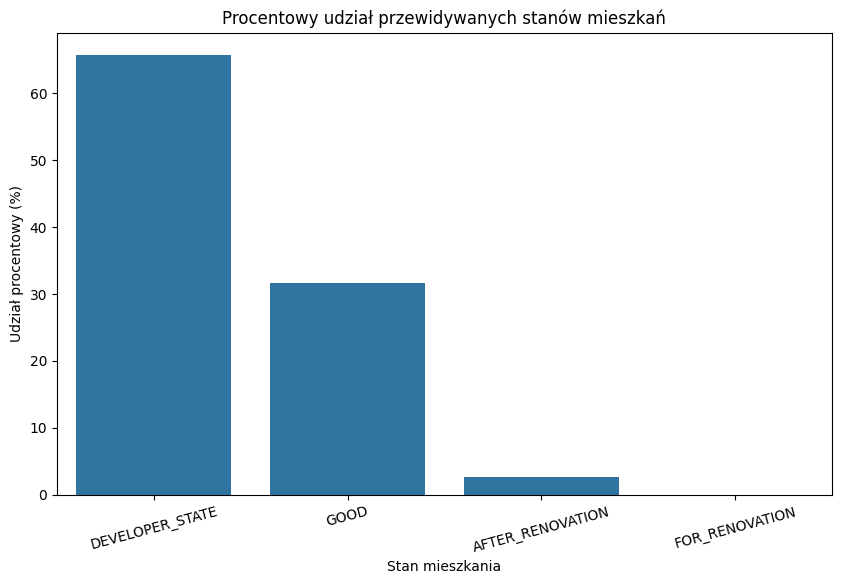

In [7]:
# --- ANALIZA WYNIKÓW FINALNEJ PREDYKCJI ---

# 1. Wczytaj plik z wynikami, jeśli jeszcze nie masz go w pamięci
# Jeśli DataFrame `df_full_predict` wciąż istnieje, możesz pominąć ten krok
# i pracować bezpośrednio na nim.
print("Wczytuję finalny plik z predykcjami...")
final_results_df = pd.read_csv('Data_state_LSTM_predicted_full.csv')
print("Plik wczytany.")

# 2. Policz liczbę wystąpień każdej kategorii w kolumnie 'Predict_State'
print("\nLiczebność poszczególnych stanów w całej bazie danych:")
state_counts = final_results_df['Predict_State'].value_counts()
print(state_counts)

# 3. Policz udziały procentowe
print("\nProcentowy udział poszczególnych stanów:")
state_percentages = final_results_df['Predict_State'].value_counts(normalize=True) * 100

# Wyświetl wyniki w ładnym formacie
for state, percentage in state_percentages.items():
    print(f"{state}: {percentage:.2f}%")

# 4. (Opcjonalnie) Wykres słupkowy dla lepszej wizualizacji
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=state_percentages.index, y=state_percentages.values)
plt.title('Procentowy udział przewidywanych stanów mieszkań')
plt.xlabel('Stan mieszkania')
plt.ylabel('Udział procentowy (%)')
plt.xticks(rotation=15)
plt.show()